<a href="https://colab.research.google.com/github/indhu-parimi/Assignment---3-RM/blob/main/Ass_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Install Required Libraries

In [1]:
pip install transformers datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


# Step 2: Load the Dataset

In [2]:
from datasets import load_dataset

# Load the IMDb dataset
dataset = load_dataset("imdb", split="train[:25%]")  # Using 25% of the data for quick training


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

# Step 3: Preprocess the Data

In [3]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/6250 [00:00<?, ? examples/s]

# Step 4: Load Pre-trained BERT Model

In [4]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Step 5: Define Training Arguments

In [5]:
training_args = TrainingArguments(
    output_dir="./results",          # Output directory
    eval_strategy="epoch",           # Evaluation strategy to use
    learning_rate=2e-5,              # Learning rate
    per_device_train_batch_size=8,   # Batch size for training
    per_device_eval_batch_size=8,    # Batch size for evaluation
    num_train_epochs=1,              # Number of epochs
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=10,
)


# Step 6: Split the Dataset

In [6]:
# Split the dataset into training and evaluation datasets
train_dataset = tokenized_dataset.shuffle(seed=42).select(range(200))  # Use first 200 examples for training
eval_dataset = tokenized_dataset.shuffle(seed=42).select(range(200, 250))  # Use the remaining 50 examples for evaluation


# Step 7: Update the Trainer

In [7]:
# Define Trainer with evaluation dataset
trainer = Trainer(
    model=model,                         # The pre-trained model
    args=training_args,                  # Training arguments
    train_dataset=train_dataset,         # Training dataset
    eval_dataset=eval_dataset            # Evaluation dataset
)

# Train the model
trainer.train()


Epoch,Training Loss,Validation Loss
1,0.111000,0.057240


TrainOutput(global_step=25, training_loss=0.21729724407196044, metrics={'train_runtime': 1312.2955, 'train_samples_per_second': 0.152, 'train_steps_per_second': 0.019, 'total_flos': 52622211072000.0, 'train_loss': 0.21729724407196044, 'epoch': 1.0})

# Step 8: Save the Model

In [8]:
# Evaluate the model
results = trainer.evaluate()

print(results)


{'eval_loss': 0.057239942252635956, 'eval_runtime': 85.3161, 'eval_samples_per_second': 0.586, 'eval_steps_per_second': 0.082, 'epoch': 1.0}


In [9]:
# Save the model and tokenizer
model.save_pretrained("./fine-tuned-bert")
tokenizer.save_pretrained("./fine-tuned-bert")


('./fine-tuned-bert/tokenizer_config.json',
 './fine-tuned-bert/special_tokens_map.json',
 './fine-tuned-bert/vocab.txt',
 './fine-tuned-bert/added_tokens.json')

Epoch,Training Loss,Validation Loss
1,0.010300,0.005531


{'eval_loss': 0.00553095480427146, 'eval_runtime': 83.2891, 'eval_samples_per_second': 0.6, 'eval_steps_per_second': 0.084, 'epoch': 1.0}


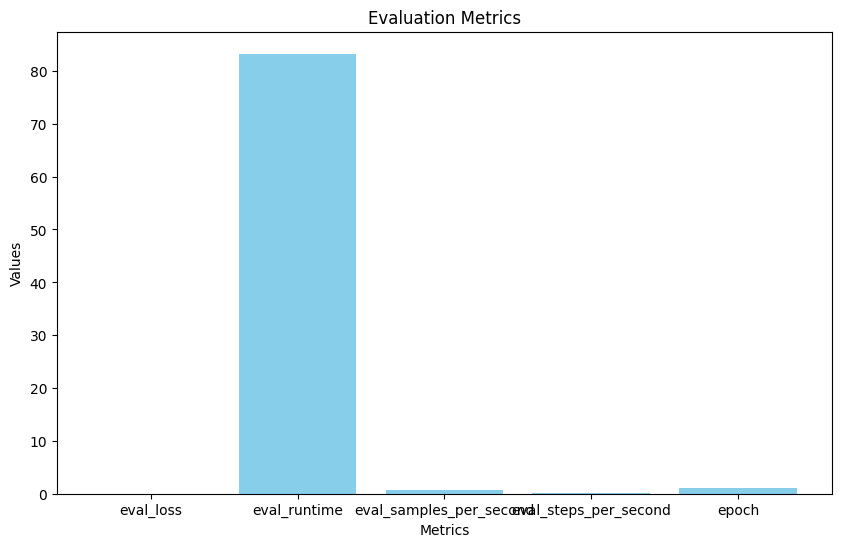

('./fine-tuned-bert/tokenizer_config.json',
 './fine-tuned-bert/special_tokens_map.json',
 './fine-tuned-bert/vocab.txt',
 './fine-tuned-bert/added_tokens.json')

In [10]:
# Split the dataset into training and evaluation datasets
train_dataset = tokenized_dataset.shuffle(seed=42).select(range(200))  # Use first 200 examples for training
eval_dataset = tokenized_dataset.shuffle(seed=42).select(range(200, 250))  # Use next 50 examples for evaluation

# Define Trainer with evaluation dataset
trainer = Trainer(
    model=model,                         # The pre-trained model
    args=training_args,                  # Training arguments
    train_dataset=train_dataset,         # Training dataset
    eval_dataset=eval_dataset            # Evaluation dataset
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()

print(results)

# Plot the evaluation metrics
import matplotlib.pyplot as plt

# Plotting the bar graph
metrics = list(results.keys())
values = list(results.values())

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color='skyblue')
plt.title("Evaluation Metrics")
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.show()

# Save the model and tokenizer
model.save_pretrained("./fine-tuned-bert")
tokenizer.save_pretrained("./fine-tuned-bert")


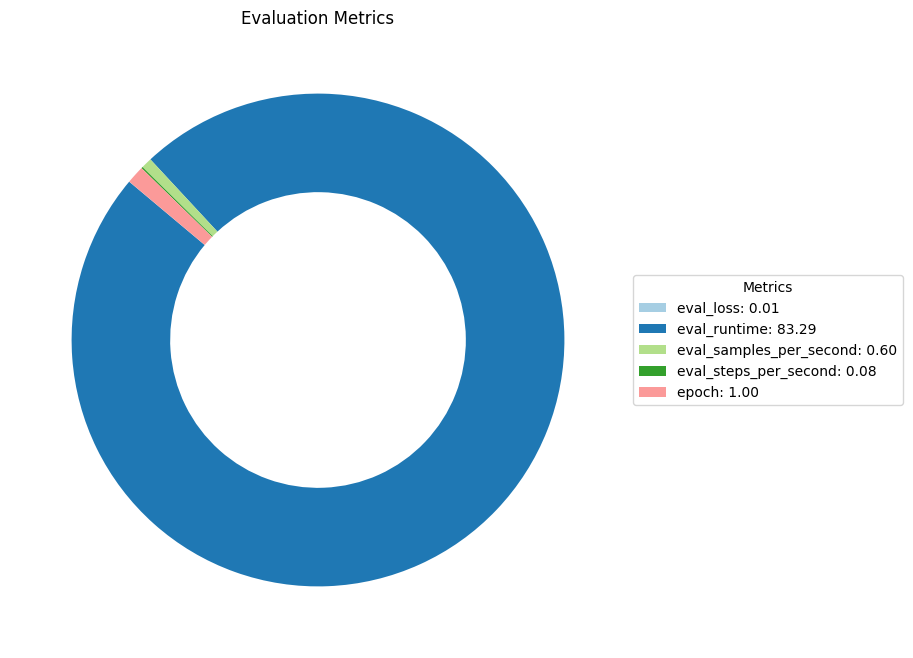

('./fine-tuned-bert/tokenizer_config.json',
 './fine-tuned-bert/special_tokens_map.json',
 './fine-tuned-bert/vocab.txt',
 './fine-tuned-bert/added_tokens.json')

In [11]:
# Plot the evaluation metrics as a donut plot without text in the chart
import matplotlib.pyplot as plt

# Plotting the donut plot
metrics = list(results.keys())
values = list(results.values())

plt.figure(figsize=(8, 8))
wedges, texts = plt.pie(
    values,
    labels=None,  # No labels on the wedges
    colors=plt.cm.Paired.colors,
    startangle=140,
    wedgeprops=dict(width=0.4)  # Makes the pie chart a donut by reducing the wedge width
)

# Add the legend with metrics and corresponding values
legend_labels = [f'{metric}: {value:.2f}' for metric, value in zip(metrics, values)]
plt.legend(wedges, legend_labels, title="Metrics", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title("Evaluation Metrics")
plt.show()

# Save the model and tokenizer
model.save_pretrained("./fine-tuned-bert")
tokenizer.save_pretrained("./fine-tuned-bert")
